# Postprocess locations from DLC and a video

In [2]:
import h5py
import os
import matplotlib.pyplot as plt

from DLC_for_WBFM.utils.postprocessing.postprocessing_utils import *
import cv2
import torch
import tifffile

from ipywidgets import interact, interactive, fixed, interact_manual
from dNMF.Demix.dNMF import dNMF
import time

/users/charles.fieseler/dNMF_parent/dNMF/WUtils/Transformations.py:1916: UserWarning: No module named 'dNMF.WUtils._transformations'
  warnings.warn(str(err))


## First, read the locations from DLC

In [3]:
which_neuron = 0;

In [4]:
# Get the video folder, then the annotation
folder_name = '/users/charles.fieseler/shared_projects/wbfm/dat/immobilized_wbfm_hardware/'
annotation_fname = '27082020_trial2_dual1_HEAD_500frames_mcherry_slice8DLC_resnet50_Chip_with_WBFM_hardware_z8Oct8shuffle1_3000.h5'
annotation_fname = os.path.join(folder_name, annotation_fname)

video_fname = '27082020_trial2_dual1_HEAD_500frames_mcherry_slice8.avi'
video_fname = os.path.join(folder_name, video_fname)

In [5]:
# Get the positions from the annotation: ONE neuron
this_xy, this_prob = xy_from_dlc_dat(annotation_fname, which_neuron=which_neuron, num_frames=500)

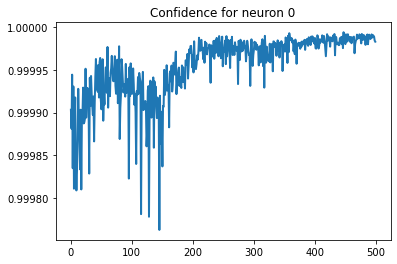

In [6]:
plt.plot(this_prob, lw=2)
# plt.ylim([0,1])
plt.title(f'Confidence for neuron {which_neuron}');

## Second, get a moving crop centering this neuron

In [7]:
# Use video from above

num_frames = 500
sz=(29,29)

cropped_dat = get_crop_from_avi(video_fname, this_xy, num_frames, sz=sz)

In [8]:
f = lambda i : plt.imshow(cropped_dat[:,:,0,i]);
interact(f, i=(0,num_frames-1));

interactive(children=(IntSlider(value=249, description='i', max=499), Output()), _dom_classes=('widget-interac…

## Run dNMF

In [9]:
# %% Choosing the parameters
params = {'n_trials':5, 'noise_level':1e-2, 'sigma_inv':.2, 
          'radius':10, 'step_S':.1, 'gamma':0, 'stride_factor':2, 'density':.1, 'varfact':5,
          'traj_means':[.0,.0,.0], 'traj_variances':[2e-4,2e-4,1e-5], 'sz':[20,20,1], 
          'K':20, 'T':100, 'roi_window':[4,4,0]}

In [10]:
# Build position and convert to pytorch
positions =[list(sz + (0,)),[0, 0, 0]] # Add a dummy position
positions = np.expand_dims(positions,2)/2.0 # Return the center of the crop
positions =  torch.tensor(positions).float()

# Also convert video to pytorch
dat = torch.tensor(cropped_dat).float()

In [ ]:
start = time.time()
# Initialize using the following from the ground truth:
#  Initial positions
#  Radius
#  
dnmf = dNMF(dat,params={'positions':positions[:,:,0][:,:,np.newaxis],\
    'radius':params['radius'],'step_S':params['step_S'],'gamma':params['gamma'],\
    'use_gpu':False,'initial_p':positions[:,:,0],'sigma_inv':params['sigma_inv'],\
    'method':'1->t', 'verbose':True})

dnmf.optimize(lr=1e-4,n_iter=20,n_iter_c=2)
end = time.time()
print('dNMF finished in ' + str(end-start) + ' seconds')

/users/charles.fieseler/dNMF_parent/dNMF/Demix/dNMF.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = torch.tensor(params['scale']).float().to(device=device).squeeze() # microns per pixel
